# Testing

In [1]:
# Global Import
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

# Local imports
from testers import single_robot_multiple, single_robot_single
from testers.helpers import imshow, get_random_coords, is_valid, is_bounded, get_area_map, get_all_area_maps
from testers.helpers import imshow, generate_no_obs_area_map, generate_point_obstacles

from cpp_algorithms.fuel_path.constants import OB, NO
from cpp_algorithms.fuel_path.fuel_path import splice_paths, get_fuel_paths
from cpp_algorithms.fuel_path.dist_matrix import dist_fill

/Users/alan/Desktop/stuff/SIH/nm_383_cpp/testers/testers.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Constants
AMS_PATH = "./test_maps/" # Area Maps Paths

## Testing Fuel Distance Map Generations

**Fuel Distance maps** generated from all the **area maps**
in the `test_maps` folder.  
Black points : Fuel

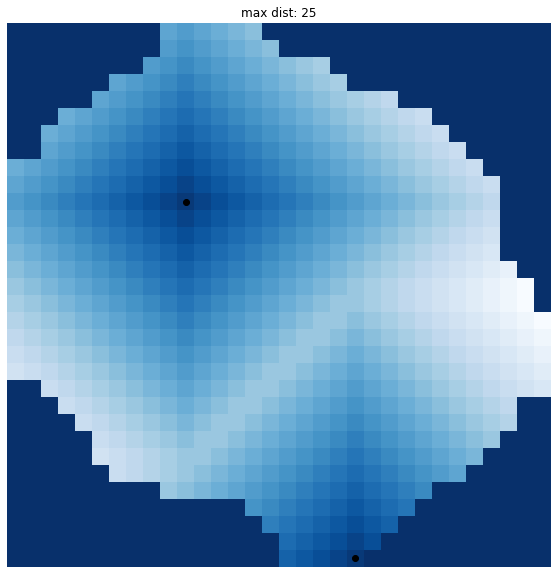

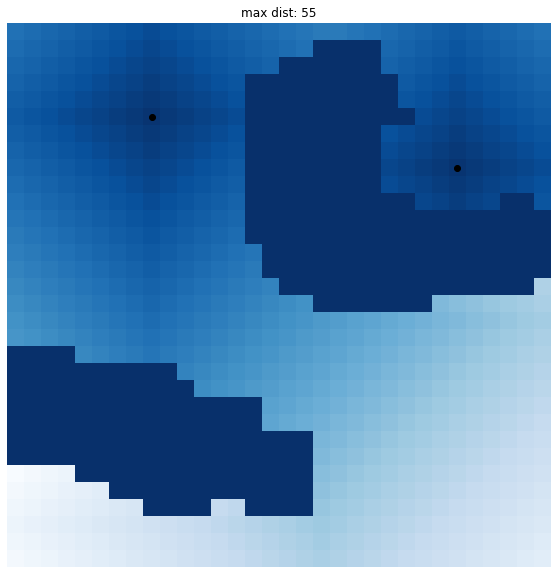

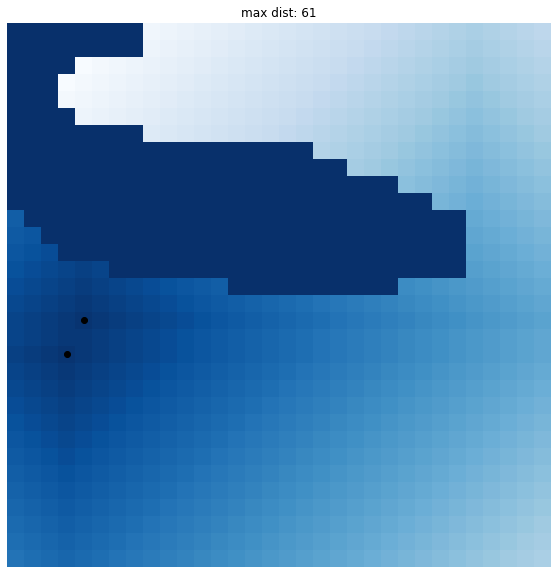

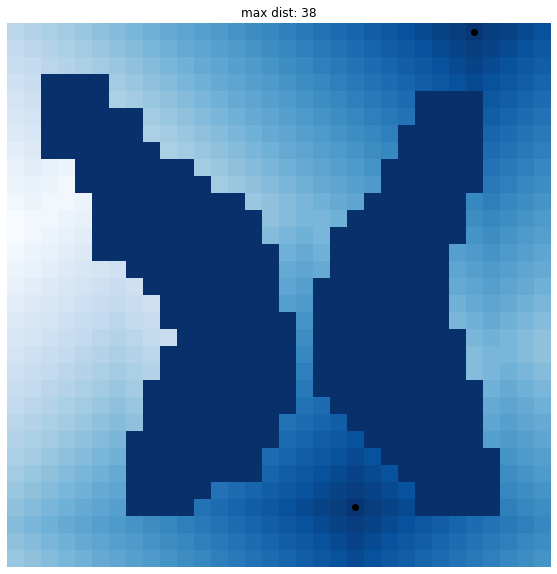

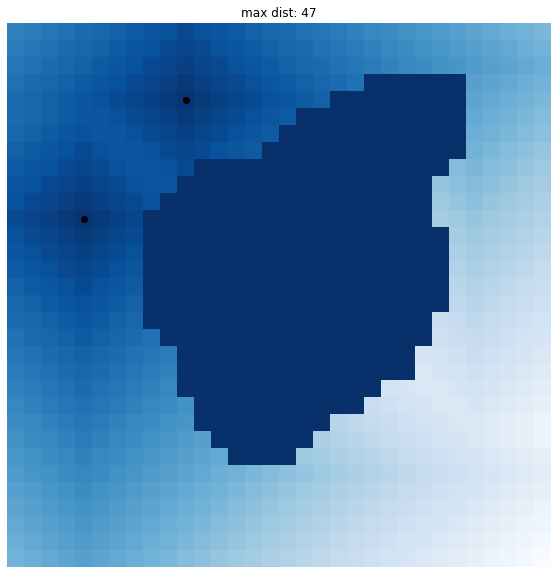

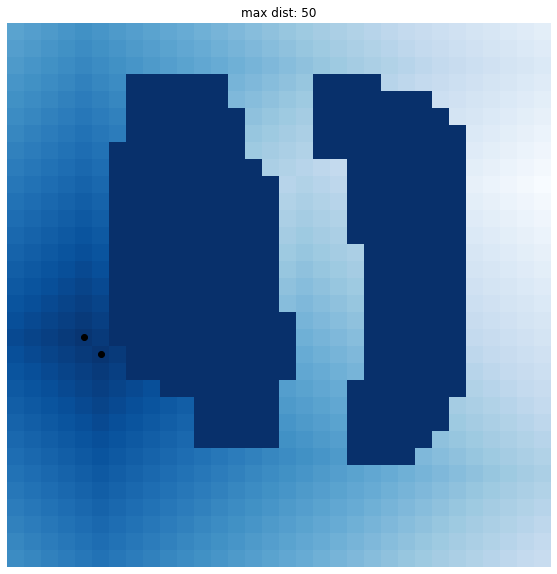

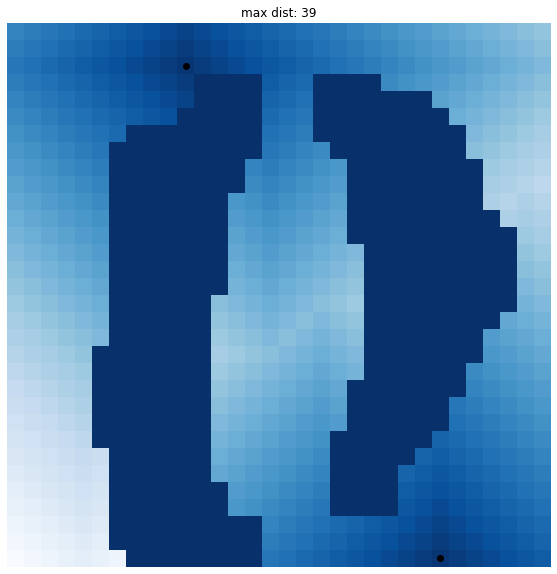

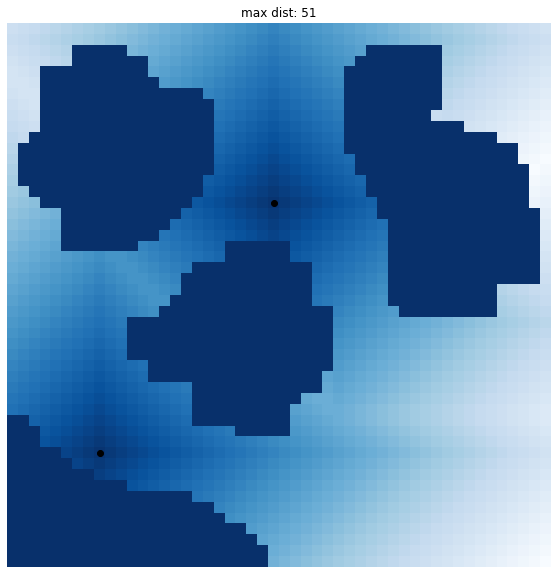

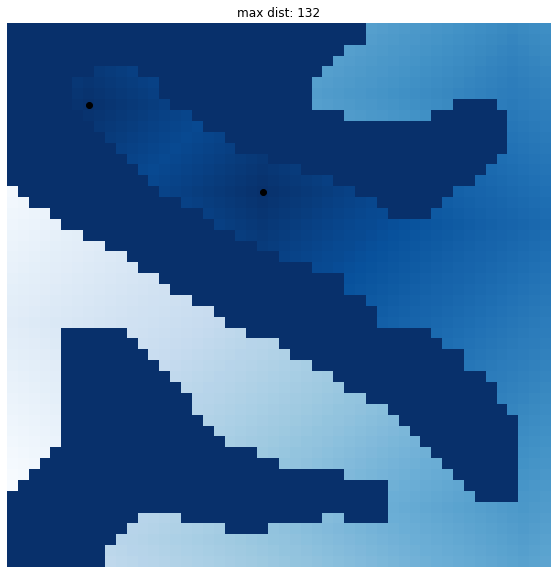

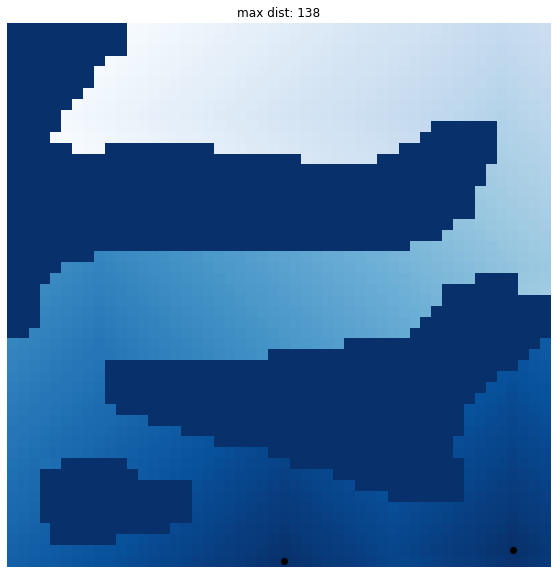

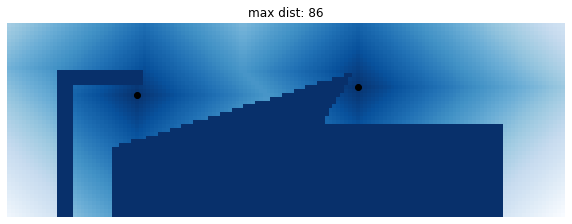

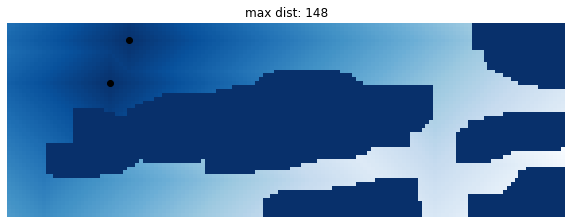

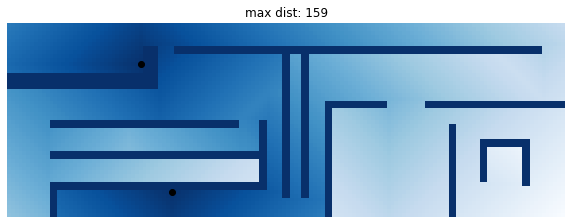

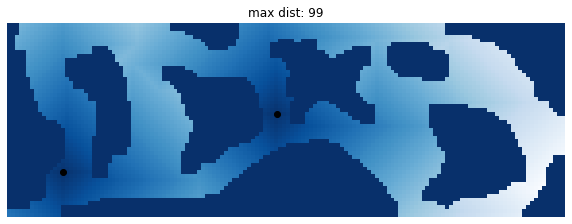

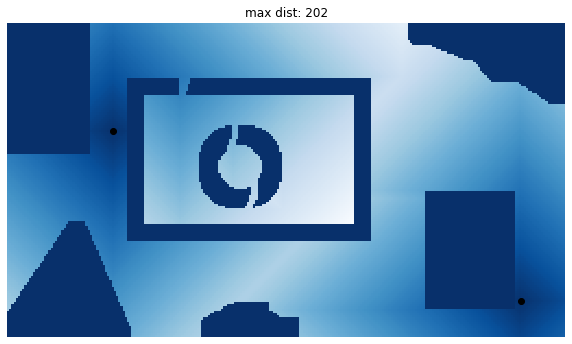

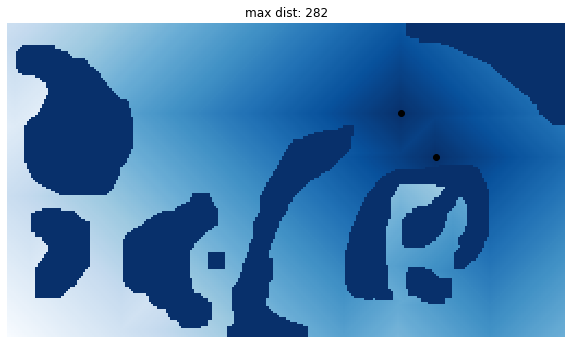

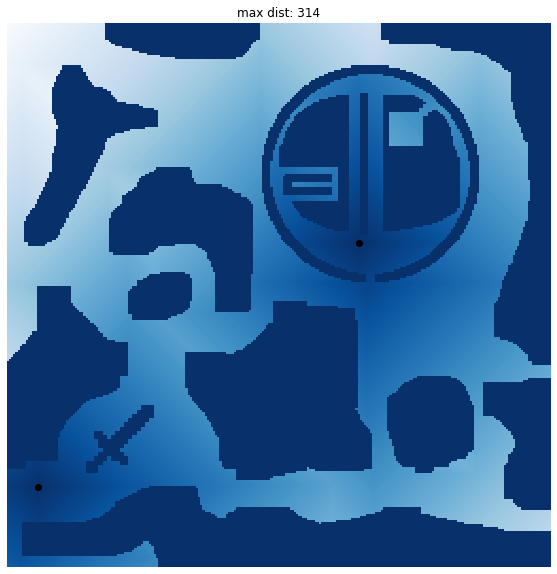

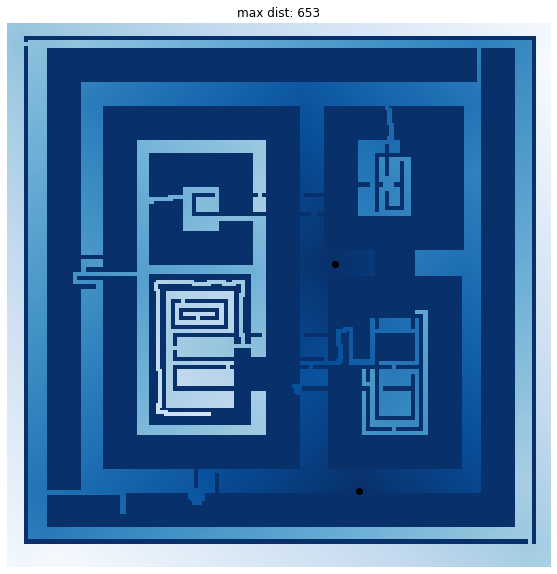

In [4]:
area_maps = get_all_area_maps("./test_maps")
for am in area_maps:
    fp = get_random_coords(am)
    dm  = dist_fill(am, fp,)
    imshow(dm,(10,10),cmap="Blues_r")
    x,y = np.array(fp).T
    plt.scatter(y,x, c="black")
    plt.title(f"max dist: {dm.max()}")

**Fuel Distance maps** generated from **point obstacles** added to no obstacle maps.  
Black points : Fuel

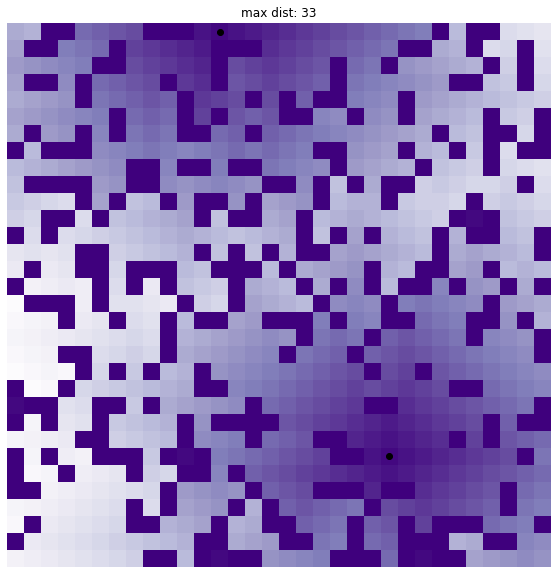

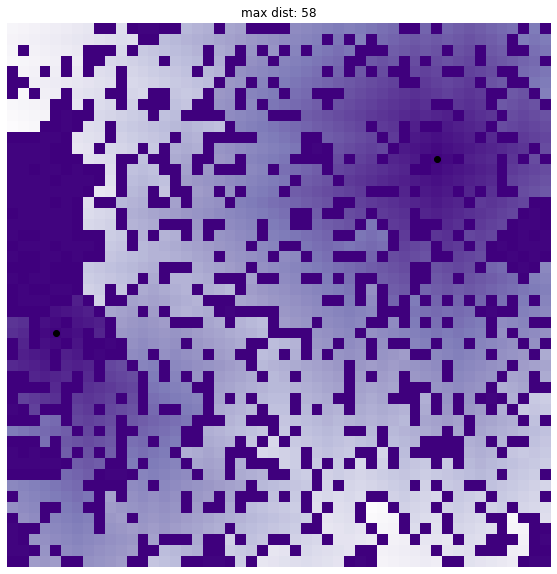

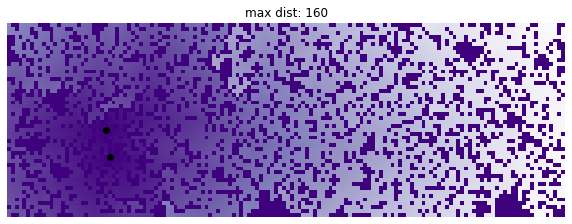

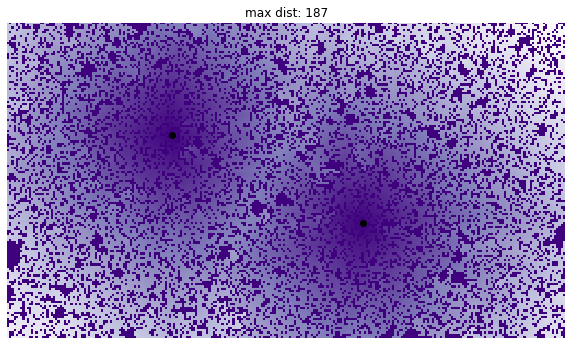

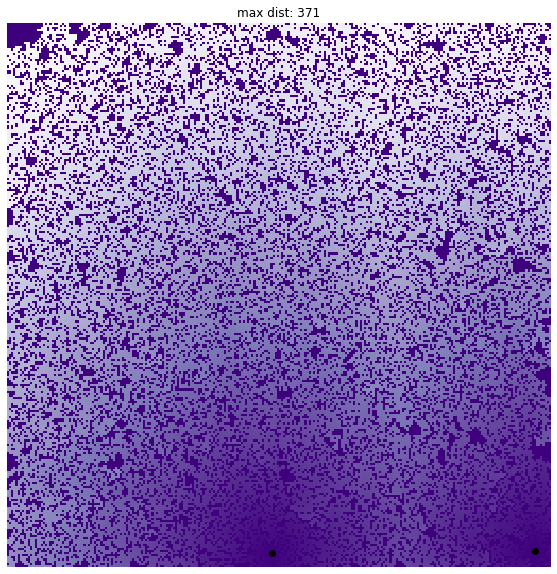

In [5]:
for am_ in generate_no_obs_area_map():
    am = generate_point_obstacles(am_, p=0.3)
    fp = get_random_coords(am)
    dm  = dist_fill(am, fp,)
    imshow(dm,(10,10),cmap="Purples_r")
    x,y = np.array(fp).T
    plt.scatter(y,x, c="black")
    plt.title(f"max dist: {dm.max()}")

## Dummy path generator

This needs to be replaced with the actual algorithms.

In [6]:
def get_next_point(dist_map, point, v_map):
    x,y = point
    points_ = [(x,y+1),(x,y-1),(x-1,y),(x+1,y)]
    sh = dist_map.shape
    
    max_ = -1
    d_vals = []
    v_vals = []
    
    points = []
    for p in points_:
        if is_bounded(p, sh) and dist_map[p] != OB:
            points.append(p)
            v_vals.append(v_map[p])
            d_vals.append(dist_map[p])
        
    d_vals = np.array(d_vals)
    v_vals = ~np.array(v_vals) # Not visited : True
    
    if v_vals.sum() == 0:
        return points[d_vals.argmin()]
    else:
        where = np.where(v_vals)[0]
        idx = where[d_vals[where].argmax()]
        return points[idx]

def traversal_path(dist_map, start):
    """
    dist_map : map of distances to the end
    start : (x,y) of the robot
    
    Assumption : end has value 0 and only
        a single end is present
    """
    shape = dist_map.shape
    v_map = (dist_map == OB).copy()
    end = tuple(np.array(np.where(dist_map==0)).flatten())
    
    point = start
    path = []
    try:
        while (~v_map).sum() > 0:
            path.append(point)
            v_map[point]  = True
            if point == end:
                break

            point = get_next_point(dist_map, point, v_map)
    except:
        return path
    return path

def dummy_coverage(area_map, start_point, end_point):
    """
    area_map : map pertaining to the area
    start_point : (x,y) where the drone starts cpp from
    end_point : (x,y) where the drone ends cpp at
    """
    assert is_valid(start_point, area_map), "invalid start"
    assert is_valid(end_point, area_map), "invalid end"
    
    dist_map = dist_fill(area_map, [end_point])
    return traversal_path(dist_map, start_point)

## Run Tests

In [7]:
# Required for animations.
# Don't forget to close the figure.
%matplotlib notebook 

### Single Robot Tests

Running the tests on multiple area maps, the first 10 in the folder.

In [8]:
single_robot_multiple(dummy_coverage, area_maps[:10])

,cp_compute_time,fp_compute_time,points_to_visit,obstacle_points,points_visited,coverage_path_len,coverage,redundancy,area_shape,fuel_path_len,fuel_capacity,max_dist_fuel
0,0.033882,0.022355,716,308,668,689,0.932961,0.030479,"(32, 32)",140.0,110,22
1,0.027604,0.007169,725,299,693,736,0.955862,0.058424,"(32, 32)",200.0,365,73
2,0.023177,0.019005,794,230,781,817,0.983627,0.044064,"(32, 32)",164.0,130,26
3,0.028456,0.006354,654,370,652,712,0.996942,0.084270,"(32, 32)",266.0,295,59
4,0.018432,0.012070,723,301,527,537,0.728907,0.018622,"(32, 32)",84.0,170,34
5,0.019386,0.006944,689,335,687,704,0.997097,0.024148,"(32, 32)",62.0,225,45
6,0.015702,0.003562,639,385,274,299,0.428795,0.083612,"(32, 32)",0.0,335,67
7,0.034130,0.010991,1529,971,843,939,0.551341,0.102236,"(50, 50)",142.0,295,59
8,0.039622,0.012132,1318,1182,1246,1344,0.945372,0.072917,"(50, 50)",306.0,650,130
9,0.055995,0.026128,1472,1028,1449,1534,0.984375,0.055411,"(50, 50)",238.0,395,79


Running the test on a single area map with the animation.

<IPython.core.display.Javascript object>


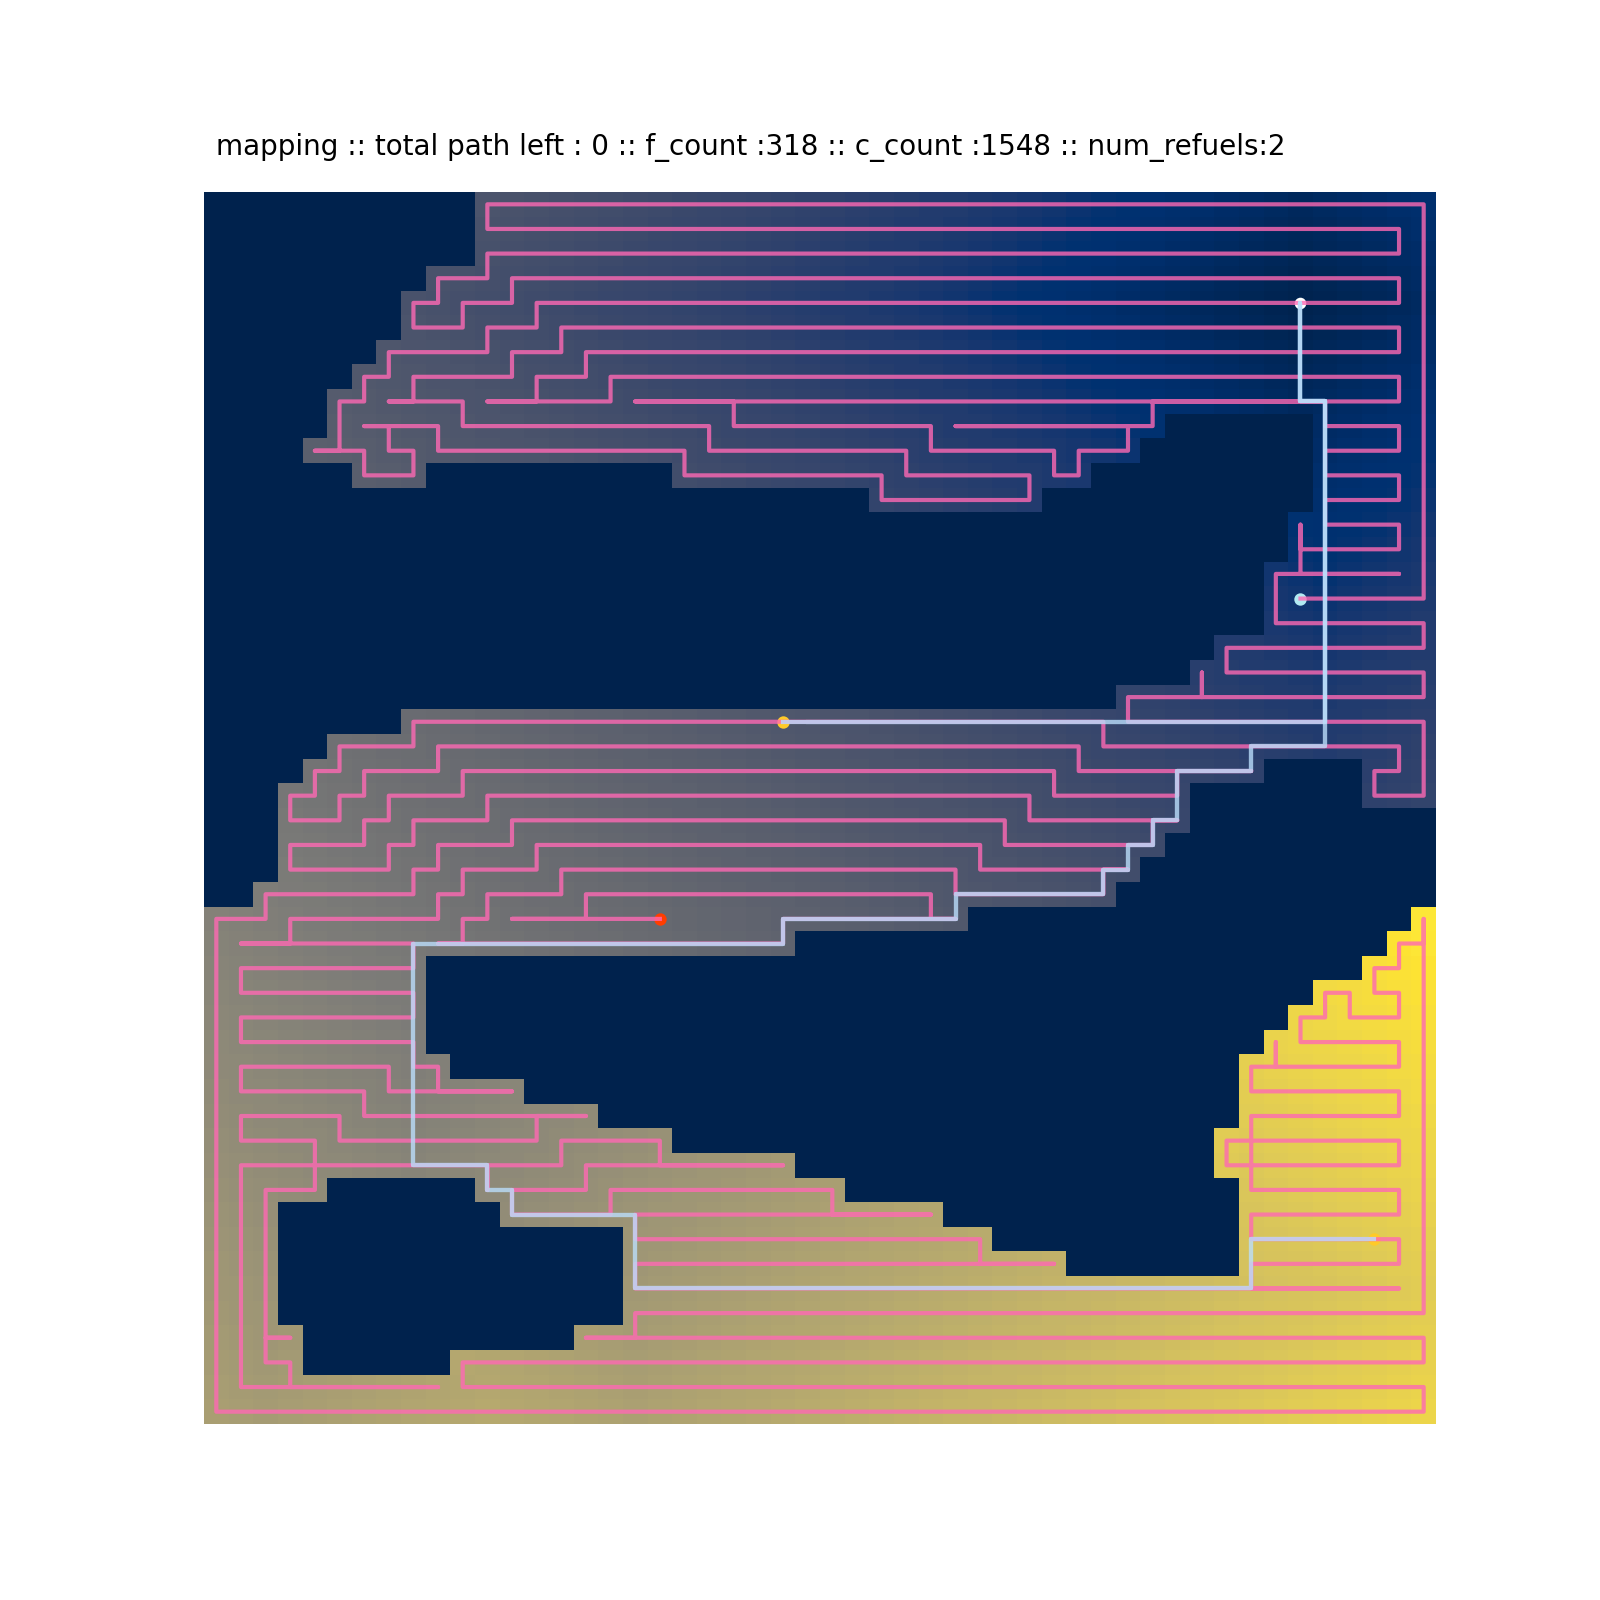

     cp_compute_time : 0.06470918655395508
     fp_compute_time : 0.011925935745239258
     points_to_visit : 1472
     obstacle_points : 1028
      points_visited : 1468
   coverage_path_len : 1548
            coverage : 0.9972826086956522
          redundancy : 0.05167958656330751
          area_shape : (50, 50)
       fuel_path_len : 322
       fuel_capacity : 670
       max_dist_fuel : 134


In [9]:
metrics, _ = single_robot_single(dummy_coverage, area_maps[9], animate=True, interval=1)

# ToDo

## Path generation API
### Single Robot Path Generation
- Generate coverage path from given area map and list of relevant points (start, end, fuel).✅
- Generate fuel path from given fuel map and coverage path.✅
- Generate combined path.✅

### Multiple Robot Path Generation
- Obtain area division map from DARP.
- Pass area division map to all algos with relevant cell value to represent mapping area.
- Same interface as single robot path generation.

## Testing
### Functions to visualize
- Animation single robot✅
- Animation multiple robots
- Map Show single robot✅
- Map show multiple robots


### Metrics
- Single Robot✅
- Multiple Robots✅
#### Percents
- **Coverage** - Percentage of non obstacle cells covered by the path.✅
- **Redundancy** - Percentage of cells from the path that have been revisited (backtracked).✅

#### Timings
- **Coverage Path computation time** - Time taken by the algorithm to compute the coverage path.✅
- **Fuel Path computation time** - Time taken to compute the refuel path.✅

#### Numbers
- **Coverage cells** - Number of cells to be covered.✅
- **Non covered cells** - Cells that haven't been covered.✅
- **Backtrack** - Count of coverage path cells that have been revisited.✅
- **Coverage Path length** - Number of steps in the area coverage path.✅
- **Fuel Path length** - Number of steps in the refueling path.✅
    
### Running Tests On/Create maps for
- Resolutions, Get obstacle maps of the following resolutions.✅
    - (32, 32)✅
    - (50, 50)✅
    - (144, 50)✅
    - (256, 144)✅
    - (256, 256)✅
- Obstacle types
    - None✅
    - Point obstacles (single cell obstacles generated randomly).✅
    - Region obstacles (region obstacles that have been painted).✅
        - Corners✅
        - Central✅
        - Caves✅
        - Pipes, Bottlenecks✅
    - Combination of both.✅